In [1]:
import pandas as pd
import re
import operator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\psari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\psari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## EDA

In [2]:
file_path = "../data/reviews.csv"
df = pd.read_csv(file_path)
df.columns

C:\Users\psari\AppData\Local\Temp\ipykernel_33280\2625179882.py:2: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')

In [3]:
# Vamos a observar tamaño del dataframe y si en sus variables encontramos datos nulos
print(len(df))
print(df.info())

34660
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourc

brand


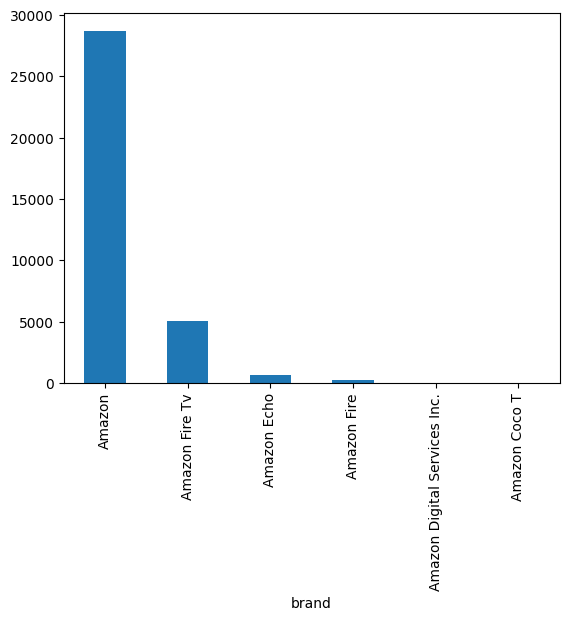

reviews.doRecommend


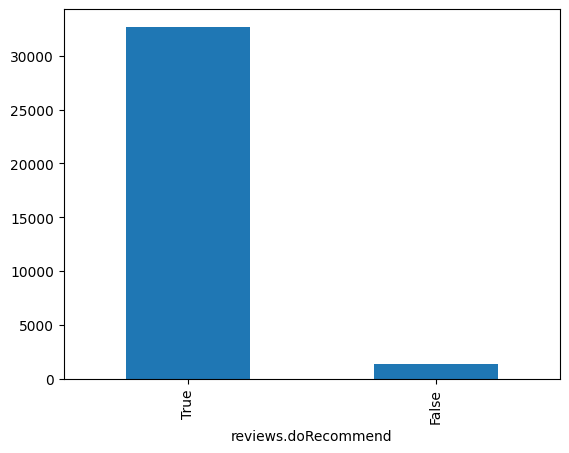

reviews.rating


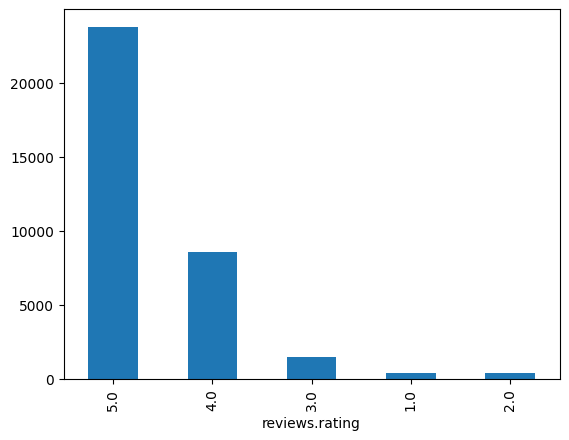

In [4]:
explorar =  ['brand','reviews.doRecommend','reviews.rating','reviews.title']

for c in explorar:
    if len(df[c].value_counts()) < 50:
        print(c)
        df[c].value_counts().plot.bar()
        plt.show()

Se observa que en la base de datos la mayoría de variables son texto y adicionalmente vemos varias columnas casi que vacias, las cuales son id (seguramente por seguridad de la información). Hay dos variables que pueden ser utiles para nuestro modelo de sentimientos **rating** o **doRecommend**. Sin embargo descartamos **doRecommend** ya que tiene mayor cantidad de valores nulos. En el siguiente parrafo explico porque si tomar la columna **rating**.

Como nuestro proposito es realizar un modelo de sentimientos, las variables que nos interesan con **reviews.text** la cual contiene texto con información del porque de su calificación y la otra variable que se dicidio incluir en este modelo es **reviews.rating**, ya que para nuestro modelo es importante brindarle información de un label que indique si la experiencia del cliente fue positiva o negativa y esta variable es una clasificación del 1 al 5 donde podemos indicar en nuestra base de datos que del 1 al 3 el sentimiento del cliente fue negativo y del 4 al 5 el sentimiento fue positivo. 

Algo importante que tambien debemos hacer en este punto es eliminar los datos faltantes tanto en la variable de reviews como rating y adicionalmente realizar la remoción de stop words y tokenizar la data de la columna que contiene los reviews

In [5]:
df.dropna(subset=['reviews.rating','reviews.text'], inplace=True)
df = df[['reviews.rating','reviews.text']]

df['reviews.text']=df['reviews.text'].apply(lambda x: " ".join([re.sub("[^A-Za-z]+",'', x) for x in nltk.word_tokenize(x)]))
df['reviews.text']=df['reviews.text'].apply(lambda x: re.sub(' +', ' ', x))
stop = stopwords.words('english')
df['tokenized_text'] = df['reviews.text'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))
print(df)

       reviews.rating                                       reviews.text  \
0                 5.0  This product so far has not disappointed My ch...   
1                 5.0  great for beginner or experienced person Bough...   
2                 5.0  Inexpensive tablet for him to use and learn on...   
3                 4.0  I ve had my Fire HD two weeks now and I love i...   
4                 5.0  I bought this for my grand daughter when she c...   
...               ...                                                ...   
34655             3.0  This is not appreciably faster than any other ...   
34656             1.0  Amazon should include this charger with the Ki...   
34657             1.0  Love my Kindle Fire but I am really disappoint...   
34658             1.0  I was surprised to find it did not come with a...   
34659             1.0  to spite the fact that i have nothing but good...   

                                          tokenized_text  
0      This product far disa

In [6]:
#Por si en el tokenized_text que se genero, queda vacia en texto y no registro como NaN
df['sequence_length'] = df['tokenized_text'].apply(len)
df = df[df['sequence_length'] > 0]

In [7]:
#Para casos negativos
df.loc[df['reviews.rating']<=3,'sentimiento'] = 0
 
#Para casos postivos
df.loc[df['reviews.rating']>3,'sentimiento'] = 1

In [7]:
df

,reviews.rating,reviews.text,tokenized_text,sequence_length,sentimiento
0,5.0,This product so far has not disappointed My ch...,This product far disappointed My children love...,98,1.0
1,5.0,great for beginner or experienced person Bough...,great beginner experienced person Bought gift ...,51,1.0
2,5.0,Inexpensive tablet for him to use and learn on...,Inexpensive tablet use learn step NABI He thri...,70,1.0
3,4.0,I ve had my Fire HD two weeks now and I love i...,I Fire HD two weeks I love This tablet great v...,365,1.0
4,5.0,I bought this for my grand daughter when she c...,I bought grand daughter comes visit I set user...,367,1.0
...,...,...,...,...,...
34655,3.0,This is not appreciably faster than any other ...,This appreciably faster higher amp charger use...,807,0.0
34656,1.0,Amazon should include this charger with the Ki...,Amazon include charger Kindle The fact chargin...,155,0.0
34657,1.0,Love my Kindle Fire but I am really disappoint...,Love Kindle Fire I really disappointed Kindle ...,225,0.0
34658,1.0,I was surprised to find it did not come with a...,I surprised find come type charging cords I pu...,147,0.0


Utilizamos un worldcloud para visualizar cuales son las palabras que mas se encuentran, en los escenarios de comentarios Negativos y Positivos 

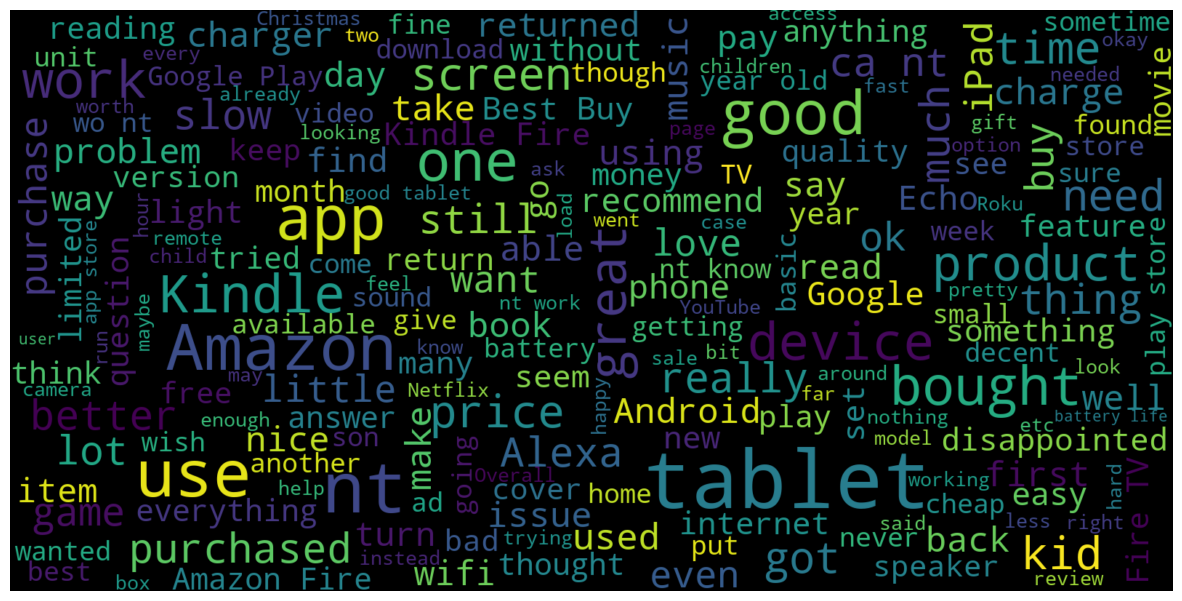

In [8]:
#Negativo
consolidated=' '.join(word for word in df['tokenized_text'][df['sentimiento']==0].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

Vemos que en este escenarios las palabras **problem, return, issue, never, dissappointed** palabras que tienen una connotación negativa se repiten, lo cual es valioso para nuestro modelo de sentimientos

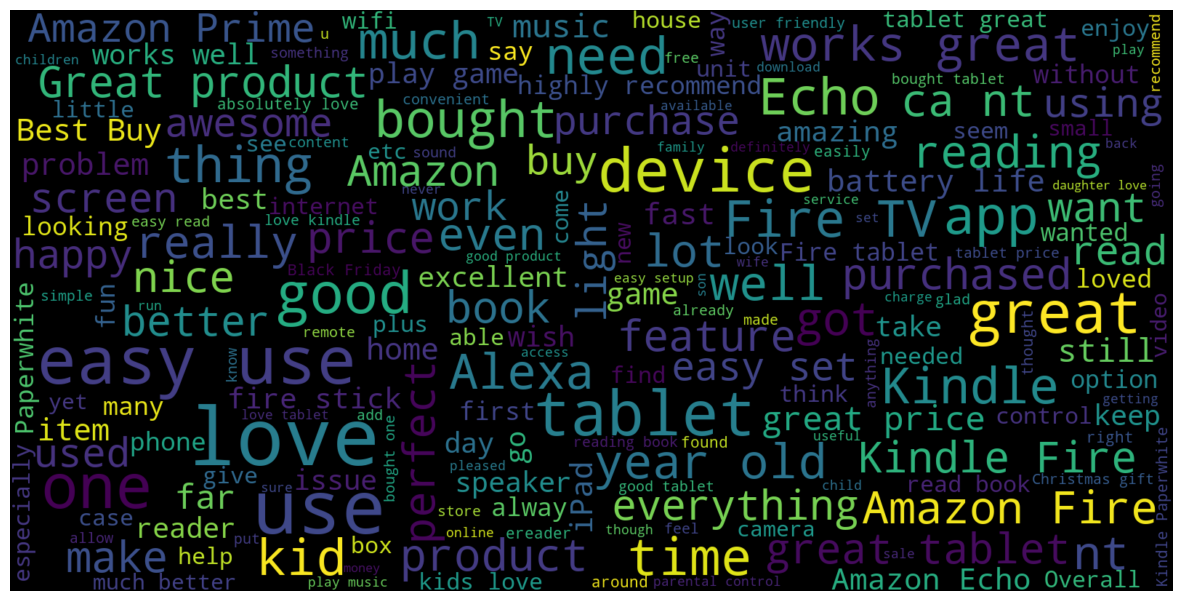

In [60]:
#Positivo
consolidated=' '.join(word for word in df['tokenized_text'][df['sentimiento']==1].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

Vemos que en este escenarios las palabras **love, good, excellent, well, nice, better, best,works, great** palabras que tienen una connotación positiva se repiten, lo cual es valioso para nuestro modelo de sentimientos

In [8]:
df['sentimiento'].value_counts()

sentimiento
1.0    32314
0.0     2311
Name: count, dtype: int64

In [9]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle
data1=df[df['sentimiento']==0][:2000]
data2=df[df['sentimiento']==1][:2000]
data = pd.concat([data1, data2], ignore_index=True)
data = data.reset_index(drop=True)
display(data['sentimiento'].value_counts())
data

sentimiento
0.0    2000
1.0    2000
Name: count, dtype: int64

,reviews.rating,reviews.text,tokenized_text,sequence_length,sentimiento
0,3.0,I ve been spoiled by Apple I bought the tablet...,I spoiled Apple I bought tablet son could He s...,126,0.0
1,1.0,Since I purchased returned couple of times now...,Since I purchased returned couple times dead I...,80,0.0
2,2.0,I did nt find it useful for my yr old daugter ...,I nt find useful yr old daugter returned dayAl...,67,0.0
3,3.0,I hate the ads They are annoying and you can n...,I hate ads They annoying get It super confusin...,66,0.0
4,3.0,Thought this came without special offers the s...,Thought came without special offers staff told...,119,0.0
...,...,...,...,...,...
3995,5.0,This is my first Amazon ereadertablet and the ...,This first Amazon ereadertablet second ereader...,215,1.0
3996,4.0,It was easy to setup The kids love it Pretty g...,It easy setup The kids love Pretty good batter...,52,1.0
3997,5.0,Great product Easy to use Tons of features A m...,Great product Easy use Tons features A must ev...,63,1.0
3998,4.0,It s a good little tablet Not the fastest thin...,It good little tablet Not fastest thing good e...,72,1.0


Por ultimo podemos observar que nuestros datos presentan un desbalanceo de clases donde la cantidad de registros positivos son aproximadamente 32000, mientras que los negativos son alrededor de 2000 registros. Actualmente en la comunidad analitica se presenta una fuerte discusión en como se deberían tratar este tipo de situaciones, para los terminos de esta prueba vamos a tomar aleatoriamente 2000 registros positivos y 2000 registros negativos. Sin embargo con aclaración para practicas futuras, sería interesante revisar un modelo donde se utilizaran los datos con la misma naturaleza que estos se encuentran.

## Machine learning

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data['tokenized_text'], data['sentimiento'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

In [11]:
print("Train: ",X_train.shape,y_train.shape,"Train: ",X_val.shape,y_val.shape,"Test: ",(X_test.shape,y_test.shape))

Train:  (2400,) (2400,) Train:  (800,) (800,) Test:  ((800,), (800,))


In [12]:
tfidf = TfidfVectorizer()

small_param_grid = [{'clf':[LogisticRegression(solver='liblinear')],
                     'clf__penalty': ['l2','elasticnet'],
                     'clf__C': [1.0, 10.0]},
                    {'clf':[SVC()],
                     'clf__C': [1.0, 10.0],
                     'clf__kernel': ['poly','rbf','sigmoid']},
                    {'clf':[MultinomialNB()],
                     'clf__alpha':[1.0]}
              ]

result=[]
scoring_metrics = ['f1_weighted', 'precision_weighted', 'recall', 'accuracy']

for params in small_param_grid:
      clf = params['clf'][0]
      params.pop('clf')
      lr_tfidf = Pipeline([('vect', tfidf),
                           ('clf', clf)])

      gs_lr_tfidf = GridSearchCV(lr_tfidf, params,
                                 scoring= scoring_metrics,
                                 refit='f1_weighted',
                                 cv=6,
                                 verbose=1,
                                 n_jobs=-1)
      gs_lr_tfidf.fit(X_train.values, y_train.values)
      
      result.append\
    (
        {
            'grid': gs_lr_tfidf,
            'classifier': gs_lr_tfidf.best_estimator_,
            'best score': gs_lr_tfidf.best_score_,
            'best params': gs_lr_tfidf.best_params_,
            'cv': gs_lr_tfidf.cv
        }
    )

Fitting 6 folds for each of 4 candidates, totalling 24 fits


c:\Prueba_tecnica\env\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Prueba_tecnica\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Prueba_tecnica\env\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Prueba_tecnica\env\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **la

Fitting 6 folds for each of 6 candidates, totalling 36 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits


In [13]:
result = sorted(result, key=operator.itemgetter('best score'),reverse=True)
print(result)

[{'grid': GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1, param_grid={'clf__alpha': [1.0]}, refit='f1_weighted',
             scoring=['f1_weighted', 'precision_weighted', 'recall',
                      'accuracy'],
             verbose=1), 'classifier': Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', MultinomialNB())]), 'best score': 0.7931482732990774, 'best params': {'clf__alpha': 1.0}, 'cv': 6}, {'grid': GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid={'clf__C': [1.0, 10.0],
                         'clf__kernel': ['poly', 'rbf', 'sigmoid']},
             refit='f1_weighted',
             scoring=['f1_weighted', 'precision_weighted', 'recall',
                      'accuracy'],
             verbose=1), 'cla

In [17]:
cv_results = gs_lr_tfidf.cv_results_
f1_score_results = cv_results['mean_test_f1_weighted']
f1_score_results

array([0.79314827])

In [18]:
best_model  = result[0]['grid']
y_pred = best_model.predict(X_test.values)

In [20]:
f1 = f1_score(y_test, y_pred)
print(f'CV f1-score: {f1:.3f}')

CV f1-score: 0.781


In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f'CV Accuracy: {accuracy:.3f}')

CV Accuracy: 0.789


## Redes neuronales

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torchtext
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import re
from collections import Counter, OrderedDict
from torchtext.vocab import vocab
from torchtext import __version__ as torchtext_version
from pkg_resources import parse_version

c:\Prueba_tecnica\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [70]:
#Para casos negativos
data.loc[data['sentimiento']==0,'sentimiento_nn'] = 'neg'
 
#Para casos postivos
data.loc[data['sentimiento']==1,'sentimiento_nn'] = 'pos'

In [8]:
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = text.split()
    return tokenized

In [13]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['tokenized_text']
        sentiment = self.dataframe.iloc[idx]['sentimiento_nn']
        return text, sentiment

In [72]:
train_val_data, test_data = train_test_split(data[['tokenized_text','sentimiento_nn']], test_size=0.2, random_state=42)
train_data,val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)

In [73]:
token_counts = Counter()
for line in train_data['tokenized_text']:
    tokens = tokenizer(line)
    token_counts.update(tokens)

print('Vocab-size:', len(token_counts))

Vocab-size: 4744


In [75]:
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)
val_dataset = CustomDataset(val_data)

In [76]:
sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

vocab = vocab(ordered_dict)

vocab.insert_token("<pad>", 0)
vocab.insert_token("<unk>", 1)
vocab.set_default_index(1)

print([vocab[token] for token in ['this', 'is', 'an', 'example']])

[19, 788, 1109, 1254]


In [77]:
if not torch.cuda.is_available():
    print("Warning: this code may be very slow on CPU")

In [9]:
## Step 3-A: define the functions for transformation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

if parse_version(torchtext.__version__) > parse_version("0.10"):
    label_pipeline = lambda x: 1. if x == 'pos' else 0.


## Step 3-B: wrap the encode and transformation function
def collate_batch(batch):
    text_list, label_list, lengths = [], [], []
    for _text, _label  in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), 
                                      dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(
        text_list, batch_first=True)
    return padded_text_list, label_list, lengths

In [79]:
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)
text_batch, label_batch, length_batch = next(iter(dataloader))
print(text_batch)
print(label_batch)
print(length_batch)
print(text_batch.shape)

tensor([[   2,   59,   39,   74,   40,   81,  265, 1474,  692,   17, 1135,    2,
           13,  366,   67,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   9,   18,  266, 1824,  118,   26,  210, 1037, 1283,   14,   56,  937,
          466,   13,    4, 1475,    8,  331, 1825,  849,  299,  791,   10, 2460,
         2461,  153,  108,  408,   92,   21,    9,  792,   85,   10,  153],
        [   5,   51,    3,   18,   12,   29,  349,   70,    4,  447,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  10,  248,    2,   12,   75,  510,  392,    2,  194,  605,  135,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])
tensor([1., 0., 1., 0.])
tensor([15, 35, 10, 11

In [80]:
## Step 4: batching the datasets

batch_size = 32  

train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(val_dataset, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)

Building an RNN model for the sentiment analysis task

In [81]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
         
vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model = model.to(device)

In [82]:
def train(dataloader):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred, label_batch)
        loss.backward()
        optimizer.step()
        total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)
 
def evaluate(dataloader):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch)
            total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset),pred

In [84]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

torch.manual_seed(1)
 
for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid,_ = evaluate(valid_dl)
    print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}')

Epoch 0 accuracy: 0.6200 val_accuracy: 0.6288
Epoch 1 accuracy: 0.6775 val_accuracy: 0.6500
Epoch 2 accuracy: 0.7087 val_accuracy: 0.6863
Epoch 3 accuracy: 0.7533 val_accuracy: 0.7013
Epoch 4 accuracy: 0.7796 val_accuracy: 0.7150
Epoch 5 accuracy: 0.8029 val_accuracy: 0.7238
Epoch 6 accuracy: 0.8250 val_accuracy: 0.7250
Epoch 7 accuracy: 0.8408 val_accuracy: 0.7125
Epoch 8 accuracy: 0.8704 val_accuracy: 0.7325
Epoch 9 accuracy: 0.8846 val_accuracy: 0.7262


In [85]:
acc_test, _, y_probs= evaluate(test_dl)
print(f'test_accuracy: {acc_test:.4f}') 

test_accuracy: 0.7338


In [40]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_loss = []
train_accuracies = []
valid_accuracies = []
torch.manual_seed(1)
 
for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(valid_dl)
    print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}')
    train_loss.append(loss_train)
    train_accuracies.append(acc_train)
    valid_accuracies.append(acc_valid)
    

Epoch 0 accuracy: 0.5317 val_accuracy: 0.5700
Epoch 1 accuracy: 0.6442 val_accuracy: 0.6713
Epoch 2 accuracy: 0.7033 val_accuracy: 0.7238
Epoch 3 accuracy: 0.7433 val_accuracy: 0.7525
Epoch 4 accuracy: 0.7738 val_accuracy: 0.7625
Epoch 5 accuracy: 0.8029 val_accuracy: 0.7688
Epoch 6 accuracy: 0.8358 val_accuracy: 0.7800
Epoch 7 accuracy: 0.8471 val_accuracy: 0.7775
Epoch 8 accuracy: 0.8629 val_accuracy: 0.7612
Epoch 9 accuracy: 0.8871 val_accuracy: 0.7675
Epoch 10 accuracy: 0.9071 val_accuracy: 0.7700
Epoch 11 accuracy: 0.9287 val_accuracy: 0.7538
Epoch 12 accuracy: 0.9396 val_accuracy: 0.7400
Epoch 13 accuracy: 0.9537 val_accuracy: 0.7400
Epoch 14 accuracy: 0.9529 val_accuracy: 0.7438
Epoch 15 accuracy: 0.9729 val_accuracy: 0.7400
Epoch 16 accuracy: 0.9646 val_accuracy: 0.7312
Epoch 17 accuracy: 0.9838 val_accuracy: 0.7338
Epoch 18 accuracy: 0.9892 val_accuracy: 0.7275
Epoch 19 accuracy: 0.9917 val_accuracy: 0.7300
Epoch 20 accuracy: 0.9938 val_accuracy: 0.7312
Epoch 21 accuracy: 0.99

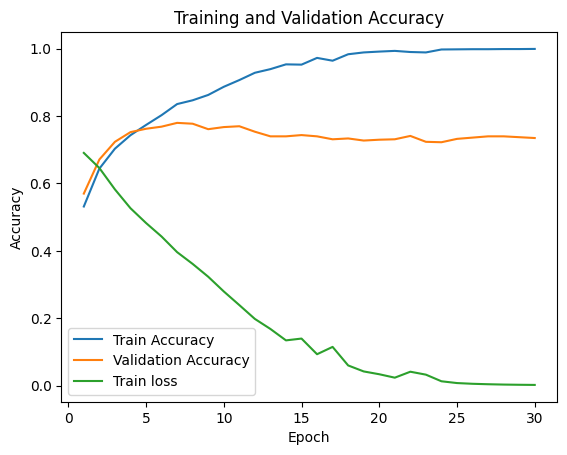

In [41]:
# Graficar las precisiones de entrenamiento y validación
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), valid_accuracies, label='Validation Accuracy')
plt.plot(range(1, num_epochs+1), train_loss, label='Train loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [87]:
_, label_test, _ = next(iter(test_dl))

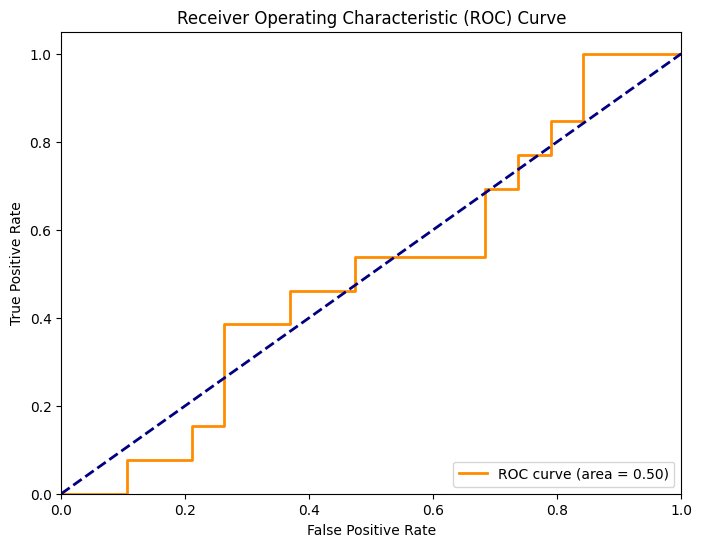

In [91]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(label_test, y_probs)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## RNN con desbalanceo de clases

In [10]:
#Para casos negativos
df.loc[df['sentimiento']==0,'sentimiento_nn2'] = 'neg'
 
#Para casos postivos
df.loc[df['sentimiento']==1,'sentimiento_nn2'] = 'pos'

In [11]:
df = df.iloc[1:,:]

In [13]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['tokenized_text']
        sentiment = self.dataframe.iloc[idx]['sentimiento_nn2']
        return text, sentiment

In [14]:
train_val_data_nn, test_data = train_test_split(df[['tokenized_text','sentimiento_nn2']], test_size=0.2, random_state=42)
train_data,val_data = train_test_split(train_val_data_nn, test_size=0.25, random_state=42)


token_counts = Counter()
for line in train_data['tokenized_text']:
    tokens = tokenizer(line)
    token_counts.update(tokens)

print('Vocab-size:', len(token_counts))


train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)
val_dataset = CustomDataset(val_data)

sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

vocab = vocab(ordered_dict)

vocab.insert_token("<pad>", 0)
vocab.insert_token("<unk>", 1)
vocab.set_default_index(1)

print([vocab[token] for token in ['this', 'is', 'an', 'example']])

if not torch.cuda.is_available():
    print("Warning: this code may be very slow on CPU")
    
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)
text_batch, label_batch, length_batch = next(iter(dataloader))
print(text_batch)
print(label_batch)
print(length_batch)
print(text_batch.shape)

batch_size = 32  

train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(val_dataset, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)

Vocab-size: 12488
[15, 627, 1162, 1233]
tensor([[ 206,  815,   26,    3,    2,   19,  299,  265,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   2,  121,   20,  158,  379,   99,   91,  449,  483,   29,    6,  292,
          719, 3588,  329,  929,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [  19,   23,   72,   80,    8,    5,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [6150, 1034,    2,  132,   18,    2,   82,  313,   17, 2973,    2,   38,
           4

In [15]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
         
vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model = model.to(device)

In [30]:
def train(dataloader):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred, label_batch)
        loss.backward()
        optimizer.step()
        total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)
 
def evaluate(dataloader):
    model.eval()
    total_acc, total_loss = 0, 0
    misclassified_pairs = []
    with torch.no_grad():
        for batch_idx, (text_batch, label_batch, lengths) in enumerate(dataloader):
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch)
            
            misclassified_indices_batch = ((pred >= 0.5).float() != label_batch).nonzero()
        
            for idx in misclassified_indices_batch.flatten().tolist():
                misclassified_pairs.append((pred[idx].item(), label_batch[idx].item()))
            
            total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)

    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset),misclassified_pairs

In [17]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

torch.manual_seed(1)
 
for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid,_ = evaluate(valid_dl)
    print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}')

Epoch 0 accuracy: 0.9315 val_accuracy: 0.9340
Epoch 1 accuracy: 0.9320 val_accuracy: 0.9340
Epoch 2 accuracy: 0.9362 val_accuracy: 0.9368
Epoch 3 accuracy: 0.9426 val_accuracy: 0.9386
Epoch 4 accuracy: 0.9486 val_accuracy: 0.9347
Epoch 5 accuracy: 0.9549 val_accuracy: 0.9359
Epoch 6 accuracy: 0.9616 val_accuracy: 0.9388
Epoch 7 accuracy: 0.9669 val_accuracy: 0.9300
Epoch 8 accuracy: 0.9724 val_accuracy: 0.9321
Epoch 9 accuracy: 0.9780 val_accuracy: 0.9193


In [43]:
acc_test, _, y_probs= evaluate(test_dl)
print(f'test_accuracy: {acc_test:.4f}') 

test_accuracy: 0.9193


In [36]:
count_actual_zeros = 0

total_misclassified = len(y_probs)

for pred, actual in y_probs:
    if actual == 0.0:
        count_actual_zeros += 1

percentage_actual_zeros = (count_actual_zeros / total_misclassified) * 100

print(f"Porcentaje de etiquetas que tienen un sentimiento negativo mal clasificadas es de: {percentage_actual_zeros:.2f}%")

Porcentaje de etiquetas que tienen un sentimiento negativo mal clasificadas es de: 47.41%


## Conclusión

Para el modelo de sentimientos, se tuvo en consideración varios modelos:

**Con Balanceo de clases**

**Machine Learning**

*F1-Score*: Debido a que tener errores tipo I y tipo II en este caso ambos son indeseables.

*Data Entrenamiento*

- MultinomialNB(), best score: 0.7931
- SVC(C=10.0), kernel: 'rbf' , best score:  0.7910
- LogisticRegression(solver='liblinear') penalty: l2, best score: 0.7894

*Data Prueba MultinomialNB()*

CV Accuracy: 0.789
CV f1-score: 0.781

**Deep learning**
- RNN : test_accuracy: 0.7338

**Sin Balanceo de clases Deep Learning**
- RNN:  test_accuracy: 0.9193

Si bien aunque el desempeño de la RNN con desbalance de clases fue muy bueno, es muy probable que el modelo no realice predicciones correctas de los modelos con sentimientos negativos. En cuanto a la RNN con el balance de clases fue de las que menor desempeño obtuvo, esto quizas podría mejorar con mas datos ya que solo se pudo utilizar un 11% de los disponibles o utilizar metodologías para duplicar la data con sentimiento negativos.  Asi que mi recomendación sería utilizar el modelo de una MultinomialNB ya que tuvo un resultado de un F1-Score 79.31%. Recordemos que el F1-Score me esta teniendo en cuenta que tan preciso soy clasificando mis datos y el  recuperacion (recall) de datos relevantes.



## Aplicación Protección

Un análisis o modelo de sentimientos es totalmente util para todas las industrias, un ejemplo claro en nuestra compañia es poder predecir los sentimientos de nuestros clientes que fueron atendidos en nuestra oficinas (Calificación NPS) o lineas de atencion disponibles y por medio del modelo poder identificar con que cliente no se realizo un buen servicio para poder darle otro tipo de ayuda o solución que no se pudo dar en su momento. Otro tipo de uso que se podría dar es para identificar las PQRS que necesitan atención prioritaria. 